[View in Colaboratory](https://colab.research.google.com/github/ZZANZU/DeeeeeepLearning/blob/master/word2vec_tensorflow.ipynb)

In [0]:
# https://github.com/minsuk-heo/python_tutorial/blob/master/data_science/nlp/word2vec_tensorflow.ipynb

# **데이터 만들기**

In [0]:
corpus = ['king is a strong man', 
          'queen is a wise woman', 
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong', 
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

# **Stop words 제거**

In [0]:
def remove_stop_words(corpus) :
    stop_words = ['is', 'a', 'will', 'be']
    results = []
    
    for text in corpus :
        tmp = text.split(' ')
        for stop_word in stop_words :
            if stop_word in tmp :
                tmp.remove(stop_word)
        results.append(" ".join(tmp))
        
    return results

In [0]:
corpus = remove_stop_words(corpus)

In [0]:
words = []

for text in corpus : 
    for word in text.split(' ') :
        words.append(word)
        
words = set(words)

word vector 생성 완료

In [7]:
words

{'boy',
 'girl',
 'king',
 'man',
 'pretty',
 'prince',
 'princess',
 'queen',
 'strong',
 'wise',
 'woman',
 'young'}

# **Data 생성**

skipgram을 위해 단어별 label을 생성

In [0]:
word2int = {}

for i,word in enumerate(words) :
    word2int[word] = i
    
sentences = []
for sentence in corpus :
    sentences.append(sentence.split())
    #print(sentences)
    
WINDOW_SIZE = 2

data = []
for sentence in sentences :
    for idx,word in enumerate(sentence) :
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] :
            if neighbor != word :
                data.append([word, neighbor])

In [10]:
import pandas as pd

for text in corpus :
    print(text)
    
df = pd.DataFrame(data, columns = ['input', 'label'])

king strong man
queen wise woman
boy young man
girl young woman
prince young king
princess young queen
man strong
woman pretty
prince boy king
princess girl queen


In [11]:
df.head(10)

,input,label
0,king,strong
1,king,man
2,strong,king
3,strong,man
4,man,king
5,man,strong
6,queen,wise
7,queen,woman
8,wise,queen
9,wise,woman


In [16]:
df.shape

(52, 2)

In [17]:
word2int

{'boy': 3,
 'girl': 8,
 'king': 0,
 'man': 11,
 'pretty': 7,
 'prince': 10,
 'princess': 6,
 'queen': 4,
 'strong': 9,
 'wise': 2,
 'woman': 1,
 'young': 5}

# **텐서플로우 그래프 정의하기**

In [0]:
import tensorflow as tf
import numpy as np

ONE_HOT_DIM = len(words)

# one-hot-encoding 벡터 생성
def to_one_hot_encoding(data_point_index) :
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    
    return one_hot_encoding

X = [] # input word
Y = [] # target word

for x, y in zip(df['input'], df['label']) :
    X.append(to_one_hot_encoding(word2int[ x ]))
    Y.append(to_one_hot_encoding(word2int[ y ]))
    
# numpy array로 변환하기
X_train = np.asarray(X)
Y_train = np.asarray(Y)

# X_train과 Y_train의 placeholder 만들기
x = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))
y_label = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))

# 2차원 word embedding
EMBEDDING_DIM = 2

# hidden layer
W1 = tf.Variable(tf.random_normal([ONE_HOT_DIM, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([1])) # bias
hidden_layer = tf.add(tf.matmul(x,W1), b1)

# output layer
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, ONE_HOT_DIM]))
b2 = tf.Variable(tf.random_normal([1]))
prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_layer, W2), b2))

# loss function : cross entropy
loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), axis=[1]))

# training operation
train_op = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

# **Train**

In [22]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

iteration = 20000

for i in range(iteration) :
    # input : X_train(one-hot encoded word)
    # label : Y_train(one-hot encoded neighbor word)
    sess.run(train_op, feed_dict={x: X_train, y_label: Y_train})
    
    if i % 3000 == 0 :
        print('iteration ' + str(i) + ' loss is : ', sess.run(loss, feed_dict={x: X_train, y_label: Y_train}))

('iteration 0 loss is : ', 3.0361037)
('iteration 3000 loss is : ', 1.8484992)
('iteration 6000 loss is : ', 1.8007156)
('iteration 9000 loss is : ', 1.7811431)
('iteration 12000 loss is : ', 1.7690017)
('iteration 15000 loss is : ', 1.760319)
('iteration 18000 loss is : ', 1.7535558)


In [23]:
# 이제 hidden layer (W1 + b1)는 lookup table
vectors = sess.run(W1 + b1)
print(vectors)

[[ 0.4248289  -0.726086  ]
 [-1.1005465   0.12198973]
 [-5.655208   -1.8428428 ]
 [ 0.1571703  -3.3498254 ]
 [-1.3833582  -0.31787777]
 [-0.12473834 -0.28332102]
 [-4.553308   -1.0071436 ]
 [-3.791718   -2.2622178 ]
 [-3.467585   -1.5021908 ]
 [ 0.8912946  -7.066959  ]
 [ 0.82857454 -2.1393926 ]
 [ 0.67266285 -0.6688042 ]]


# **Word Vector 테이블**

In [24]:
w2v_df = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v_df['word'] = words
w2v_df = w2v_df[['word', 'x1', 'x2']]
w2v_df

,word,x1,x2
0,king,0.424829,-0.726086
1,woman,-1.100546,0.121990
2,wise,-5.655208,-1.842843
3,boy,0.157170,-3.349825
4,queen,-1.383358,-0.317878
5,young,-0.124738,-0.283321
6,princess,-4.553308,-1.007144
7,pretty,-3.791718,-2.262218
8,girl,-3.467585,-1.502191
9,strong,0.891295,-7.066959


# **2차원 공간에 표시해보기**

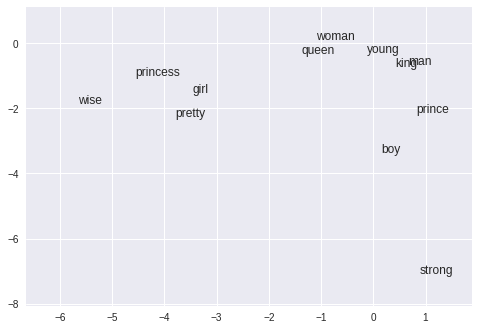

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1,x2 ))
    
PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING
 
plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.rcParams["figure.figsize"] = (10,10)

plt.show()